In [1]:
import ktrain
from ktrain import text
import pandas as pd
import numpy as np
from sklearn.utils import shuffle, resample

## Load the data

In [2]:
news = pd.read_csv("/home/jupyter-ozkan_ma/data/CSV/news_preprocessed_with_addtionalLabel.csv", index_col=0)

In [3]:
# Get the same train and test data
def split_df_in_train_test(df):
    df = df.reset_index()
    split_point = int(np.round(df.shape[0]) * 0.8)
    df_train = df.loc[:split_point-1,:]
    df_test = df.loc[split_point:,:]
    return df_train, df_test

In [4]:
left_AbSt_02 = resample(shuffle(news[(news["Label_AbStudy_02"]=="Left") & (news["Length"]<512)], random_state=42), \
         random_state=42, n_samples=25000)
center_AbSt_02 = resample(shuffle(news[(news["Label_AbStudy_02"]=="Center") & (news["Length"]<512)], random_state=42), \
         random_state=42, n_samples=25000)
right_AbSt_02 = resample(shuffle(news[(news["Label_AbStudy_02"]=="Right") & (news["Length"]<512)], random_state=42), \
         random_state=42, n_samples=25000)

In [5]:
train = pd.concat([split_df_in_train_test(left_AbSt_02)[0], \
    split_df_in_train_test(center_AbSt_02)[0], \
    split_df_in_train_test(right_AbSt_02)[0]])

In [6]:
test = pd.concat([split_df_in_train_test(left_AbSt_02)[1], \
    split_df_in_train_test(center_AbSt_02)[1], \
    split_df_in_train_test(right_AbSt_02)[1]])

In [7]:
x_train = train["content"].to_list()
y_train = train["Label_AbStudy_02"].to_list()
x_test = test["content"].to_list()
y_test = test["Label_AbStudy_02"].to_list()

In [8]:
class_names = list(train["Label_AbStudy_02"].unique())

## Build the model

In [13]:
model_name = "roberta-base"

In [14]:
t = text.Transformer(model_name, maxlen=512, class_names=class_names)

In [15]:
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 252
	95percentile : 481
	99percentile : 506


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 254
	95percentile : 481
	99percentile : 505


In [16]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

simulating training for different learning rates... this may take a few moments...
10000/10000 [==============================] - 3543s 354ms/step - loss: 9.7925 - accuracy: 0.4534


done.
Visually inspect loss plot and select learning rate associated with falling loss


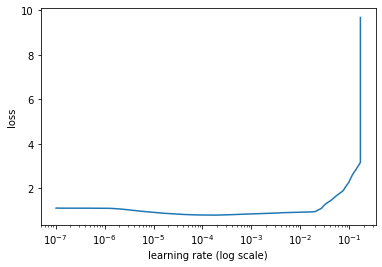

In [18]:
learner.lr_find(show_plot=True, max_epochs=1)

In [19]:
optimal_lr = learner.lr_estimate()[1]
print(optimal_lr)

1.8603754870127887e-05


In [20]:
learner.fit(optimal_lr, 1)

10000/10000 [==============================] - 3803s 380ms/step - loss: 0.3523 - accuracy: 0.8644 - val_loss: 0.2613 - val_accuracy: 0.9076


In [21]:
learner.validate(class_names=class_names)

              precision    recall  f1-score   support

        Left       0.89      0.93      0.91      5000
      Center       0.89      0.92      0.91      5000
       Right       0.94      0.87      0.91      5000

    accuracy                           0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000



array([[4654,  204,  142],
       [ 270, 4590,  140],
       [ 281,  349, 4370]])